In [46]:
# Feature Engineering for IPL Analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



# Import helper functions
import sys
sys.path.append('../src')

from feature_engineering import (
    calculate_team_form,
    get_h2h_stats,
    calculate_venue_stats,
    calculate_toss_impact,
    get_season_stats,
    create_match_context_features,
    aggregate_bowling_innings
)

print("All imports successful!")

# Load cleaned datasets
matches = pd.read_csv('../data/processed/matches_clean.csv')
deliveries = pd.read_csv('../data/processed/deliveries_clean.csv')

# Convert date to datetime
matches['date'] = pd.to_datetime(matches['date'])

print("Datasets loaded successfully!")
print(f"Matches shape: {matches.shape}")
print(f"Deliveries shape: {deliveries.shape}")

All imports successful!
Datasets loaded successfully!
Matches shape: (1095, 20)
Deliveries shape: (260920, 17)


In [47]:
def clean_season(season):
    """Convert season format from YYYY/YY to the first year"""
    if pd.isna(season):
        return season
    season_str = str(season)
    if '/' in season_str:
        # Take the first part and return as integer
        return int(season_str.split('/')[0])
    else:
        return int(season_str)

matches['season'] = matches['season'].apply(clean_season)

print("Datasets loaded successfully!")
print(f"Matches shape: {matches.shape}")
print(f"Deliveries shape: {deliveries.shape}")
print(f"Unique seasons: {sorted(matches['season'].unique())}")

Datasets loaded successfully!
Matches shape: (1095, 20)
Deliveries shape: (260920, 17)
Unique seasons: [np.int64(2007), np.int64(2009), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [48]:
# =====================================
# 1. TEAM-LEVEL FEATURES
# =====================================
print("\n" + "="*50)
print("CREATING TEAM-LEVEL FEATURES")
print("="*50)

# Initialize feature dataframe
features_list = []

for idx, row in matches.iterrows():
    if idx % 100 == 0:
        print(f"Processing match {idx}/{len(matches)}")
    
    match_features = {
        'match_id': row['id'],
        'season': row['season'],
        'date': row['date'],
        'venue': row['venue'],
        'city': row['city'],
        'team1': row['team1'],
        'team2': row['team2'],
        'toss_winner': row['toss_winner'],
        'toss_decision': row['toss_decision'],
        'winner': row['winner']
    }
    
    # Team form (last 5 matches)
    match_features['team1_form'] = calculate_team_form(matches, row['team1'], row['date'])
    match_features['team2_form'] = calculate_team_form(matches, row['team2'], row['date'])
    
    # Head-to-head stats
    h2h = get_h2h_stats(matches, row['team1'], row['team2'], row['date'])
    match_features.update(h2h)
    
    # Venue-specific performance
    team1_venue = calculate_venue_stats(matches, row['team1'], row['venue'], row['date'])
    team2_venue = calculate_venue_stats(matches, row['team2'], row['venue'], row['date'])
    
    match_features['team1_venue_win_rate'] = team1_venue['venue_win_rate']
    match_features['team2_venue_win_rate'] = team2_venue['venue_win_rate']
    match_features['team1_venue_matches'] = team1_venue['venue_matches']
    match_features['team2_venue_matches'] = team2_venue['venue_matches']
    
    # Toss impact
    match_features['team1_toss_impact'] = calculate_toss_impact(matches, row['team1'], row['date'])
    match_features['team2_toss_impact'] = calculate_toss_impact(matches, row['team2'], row['date'])
    
    # Season performance
    team1_season = get_season_stats(matches, row['team1'], row['season'])
    team2_season = get_season_stats(matches, row['team2'], row['season'])
    
    match_features['team1_season_win_rate'] = team1_season['season_win_rate']
    match_features['team2_season_win_rate'] = team2_season['season_win_rate']
    match_features['team1_season_matches'] = team1_season['season_matches']
    match_features['team2_season_matches'] = team2_season['season_matches']
    
    # Match context features
    context_features = create_match_context_features(row, matches)
    match_features.update(context_features)
    
    features_list.append(match_features)

# Create features dataframe
features_df = pd.DataFrame(features_list)

print(f"\nTeam features created: {features_df.shape}")
print("\nFeature columns created:")
for col in features_df.columns:
    if col not in ['match_id', 'date', 'venue', 'city', 'team1', 'team2', 'winner']:
        print(f"  - {col}")


CREATING TEAM-LEVEL FEATURES
Processing match 0/1095
Processing match 100/1095
Processing match 200/1095
Processing match 300/1095
Processing match 400/1095
Processing match 500/1095
Processing match 600/1095
Processing match 700/1095
Processing match 800/1095
Processing match 900/1095
Processing match 1000/1095

Team features created: (1095, 27)

Feature columns created:
  - season
  - toss_winner
  - toss_decision
  - team1_form
  - team2_form
  - h2h_matches
  - team1_h2h_win_rate
  - team1_venue_win_rate
  - team2_venue_win_rate
  - team1_venue_matches
  - team2_venue_matches
  - team1_toss_impact
  - team2_toss_impact
  - team1_season_win_rate
  - team2_season_win_rate
  - team1_season_matches
  - team2_season_matches
  - is_day_match
  - is_playoff
  - season_phase


In [ ]:
# =====================================
# 2. BATTING PERFORMANCE FEATURES
# =====================================

print("\n" + "="*50)
print("CREATING BATTING PERFORMANCE FEATURES")
print("="*50)

# Aggregate batting stats per match
batting_features = []

for match_id in deliveries['match_id'].unique():
    if len(batting_features) % 100 == 0:
        print(f"Processing match {len(batting_features)}/{len(deliveries['match_id'].unique())}")
    
    match_deliveries = deliveries[deliveries['match_id'] == match_id]
    
    # First innings
    first_innings = aggregate_bowling_innings(deliveries, match_id, 1)
    if first_innings:
        first_innings['match_id'] = match_id
        first_innings['innings'] = 1
        batting_features.append(first_innings)
    
    # Second innings (if exists)
    second_innings = aggregate_bowling_innings(deliveries, match_id, 2)
    if second_innings:
        second_innings['match_id'] = match_id
        second_innings['innings'] = 2
        batting_features.append(second_innings)

batting_df = pd.DataFrame(batting_features)

# Pivot to get team1 and team2 batting features
batting_pivot = batting_df.pivot_table(
    index='match_id',
    columns='innings',
    values=['powerplay_runs', 'powerplay_wickets', 'middle_runs', 
            'middle_wickets', 'death_runs', 'death_wickets', 'total_runs', 'total_wickets'],
    fill_value=0
)

# Flatten column names
batting_pivot.columns = [f'innings{col[1]}_{col[0]}' for col in batting_pivot.columns]
batting_pivot.reset_index(inplace=True)

# Merge with main features
features_df = features_df.merge(batting_pivot, on='match_id', how='left')

print(f"\nBatting features added: {batting_pivot.shape[1]-1} new features")


CREATING BATTING PERFORMANCE FEATURES
Processing match 0/1095
Processing match 100/1095
Processing match 200/1095
Processing match 300/1095
Processing match 400/1095
Processing match 1000/1095
Processing match 1100/1095
Processing match 1200/1095
Processing match 1300/1095
Processing match 1400/1095
Processing match 1500/1095
Processing match 1600/1095
Processing match 1700/1095
Processing match 1800/1095
Processing match 1900/1095

Batting features added: 16 new features


In [50]:
print("\n" + "="*50)
print("CREATING PLAYER IMPACT FEATURES")
print("="*50)

# First, let's check what columns we have in deliveries
print("Deliveries columns:", deliveries.columns.tolist())

# Get top players for each team based on overall performance
def get_top_players_per_team(deliveries_df, team_name, n_batsmen=3, n_bowlers=2):
    """Get top performing players for a team"""
    
    # Get match IDs where team played
    team_matches = matches[(matches['team1'] == team_name) | (matches['team2'] == team_name)]
    team_match_ids = team_matches['id'].values
    
    # Check for correct column names - they might be 'batter' instead of 'batsman'
    batter_col = 'batter' if 'batter' in deliveries_df.columns else 'batsman'
    striker_col = 'striker' if 'striker' in deliveries_df.columns else batter_col
    
    # Top batsmen
    team_batting = deliveries_df[
        (deliveries_df['match_id'].isin(team_match_ids)) &
        (deliveries_df['batting_team'] == team_name)
    ]
    
    if len(team_batting) > 0 and striker_col in team_batting.columns:
        # Check for runs column name
        runs_col = 'runs_off_bat' if 'runs_off_bat' in deliveries_df.columns else 'batsman_runs'
        if runs_col not in deliveries_df.columns:
            runs_col = 'total_runs'  # fallback
        
        batsmen_runs = team_batting.groupby(striker_col)[runs_col].sum().sort_values(ascending=False).head(n_batsmen)
    else:
        batsmen_runs = pd.Series([])
    
    # Top bowlers
    team_bowling = deliveries_df[
        (deliveries_df['match_id'].isin(team_match_ids)) &
        (deliveries_df['bowling_team'] == team_name)
    ]
    
    if len(team_bowling) > 0 and 'bowler' in team_bowling.columns:
        # Check for wicket column name
        wicket_col = 'wicket_type' if 'wicket_type' in deliveries_df.columns else 'player_dismissed'
        if wicket_col in team_bowling.columns:
            bowler_wickets = team_bowling[team_bowling[wicket_col].notna()].groupby('bowler').size().sort_values(ascending=False).head(n_bowlers)
        else:
            bowler_wickets = pd.Series([])
    else:
        bowler_wickets = pd.Series([])
    
    return batsmen_runs.index.tolist() if len(batsmen_runs) > 0 else [], \
           bowler_wickets.index.tolist() if len(bowler_wickets) > 0 else []

# Store top players per team
team_top_players = {}
for team in matches['team1'].unique():
    if pd.notna(team):
        top_batsmen, top_bowlers = get_top_players_per_team(deliveries, team)
        team_top_players[team] = {
            'batsmen': top_batsmen[:2] if len(top_batsmen) >= 2 else top_batsmen,  # Take top 2 batsmen
            'bowlers': top_bowlers[:1] if len(top_bowlers) >= 1 else top_bowlers   # Take top 1 bowler
        }

print(f"Identified top players for {len(team_top_players)} teams")

# Show sample of top players
sample_teams = list(team_top_players.keys())[:3]
for team in sample_teams:
    print(f"\n{team}:")
    print(f"  Top batsmen: {team_top_players[team]['batsmen']}")
    print(f"  Top bowler: {team_top_players[team]['bowlers']}")



CREATING PLAYER IMPACT FEATURES
Deliveries columns: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs', 'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder']
Identified top players for 15 teams

Royal Challengers Bengaluru:
  Top batsmen: ['V Kohli', 'AB de Villiers']
  Top bowler: ['YS Chahal']

Punjab Kings:
  Top batsmen: ['KL Rahul', 'SE Marsh']
  Top bowler: ['PP Chawla']

Delhi Capitals:
  Top batsmen: ['RR Pant', 'DA Warner']
  Top bowler: ['A Mishra']


In [51]:
# =====================================
# 4. DERIVED FEATURES
# =====================================

print("\n" + "="*50)
print("CREATING DERIVED FEATURES")
print("="*50)

# Form difference
features_df['form_difference'] = features_df['team1_form'] - features_df['team2_form']

# Venue advantage
features_df['venue_advantage'] = features_df['team1_venue_win_rate'] - features_df['team2_venue_win_rate']

# Season momentum
features_df['season_momentum_diff'] = features_df['team1_season_win_rate'] - features_df['team2_season_win_rate']

# Toss advantage
features_df['toss_advantage'] = features_df.apply(
    lambda x: x['team1_toss_impact'] if x['toss_winner'] == x['team1'] 
    else (x['team2_toss_impact'] if x['toss_winner'] == x['team2'] else 0),
    axis=1
)

# Home advantage (simplified - team playing in their home city)
home_cities = {
    'Mumbai Indians': 'Mumbai',
    'Chennai Super Kings': 'Chennai',
    'Kolkata Knight Riders': 'Kolkata',
    'Royal Challengers Bangalore': 'Bangalore',
    'Delhi Capitals': 'Delhi',
    'Delhi Daredevils': 'Delhi',
    'Rajasthan Royals': 'Jaipur',
    'Kings XI Punjab': 'Mohali',
    'Sunrisers Hyderabad': 'Hyderabad',
    'Deccan Chargers': 'Hyderabad'
}

features_df['team1_home'] = features_df.apply(
    lambda x: 1 if home_cities.get(x['team1']) == x['city'] else 0, axis=1
)
features_df['team2_home'] = features_df.apply(
    lambda x: 1 if home_cities.get(x['team2']) == x['city'] else 0, axis=1
)

print(f"Created {5} derived features")


CREATING DERIVED FEATURES
Created 5 derived features


In [52]:

# =====================================
# 5. FEATURE STATISTICS
# =====================================

print("\n" + "="*50)
print("FEATURE STATISTICS")
print("="*50)

# Display basic statistics for numerical features
numerical_features = [col for col in features_df.columns 
                     if col not in ['match_id', 'date', 'venue', 'city', 
                                   'team1', 'team2', 'winner', 'toss_winner', 
                                   'toss_decision', 'season_phase']]

print(f"\nNumerical features summary ({len(numerical_features)} features):")
print(features_df[numerical_features].describe())

# Check for missing values
missing_values = features_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if len(missing_values) > 0:
    print("\nFeatures with missing values:")
    print(missing_values)
else:
    print("\nNo missing values in features!")



FEATURE STATISTICS

Numerical features summary (39 features):
            season   team1_form   team2_form  h2h_matches  team1_h2h_win_rate  \
count  1095.000000  1095.000000  1095.000000  1095.000000         1095.000000   
mean   2016.018265     0.498097     0.500335    11.613699            0.491328   
std       5.109016     0.224332     0.227660     9.450129            0.223652   
min    2007.000000     0.000000     0.000000     0.000000            0.000000   
25%    2012.000000     0.400000     0.400000     3.000000            0.400000   
50%    2016.000000     0.500000     0.500000    10.000000            0.500000   
75%    2021.000000     0.600000     0.600000    19.000000            0.593171   
max    2024.000000     1.000000     1.000000    36.000000            1.000000   

       team1_venue_win_rate  team2_venue_win_rate  team1_venue_matches  \
count           1095.000000           1095.000000          1095.000000   
mean               0.516621              0.507871          

In [58]:
print("\n" + "="*50)
print("SAVING ENGINEERED FEATURES")
print("="*50)

# Save main features
features_df.to_csv('../data/processed/match_features_engineered.csv', index=False)
print(f"Saved match features: {features_df.shape}")

# Check column names in deliveries to use correct ones
print("\nChecking deliveries columns for player stats...")
print("Columns available:", deliveries.columns.tolist())

# Determine correct column names
batter_col = 'batter' if 'batter' in deliveries.columns else ('striker' if 'striker' in deliveries.columns else 'batsman')
runs_col = 'runs_off_bat' if 'runs_off_bat' in deliveries.columns else ('batsman_runs' if 'batsman_runs' in deliveries.columns else 'total_runs')

print(f"Using columns: batter={batter_col}, runs={runs_col}")

# Create player statistics dataset for clustering
if batter_col in deliveries.columns and runs_col in deliveries.columns:
    player_batting = deliveries.groupby(batter_col).agg({
        runs_col: ['sum', 'mean'],
        'ball': 'count'
    }).round(2)
    
    player_batting.columns = ['total_runs', 'avg_runs_per_ball', 'balls_faced']
    player_batting['strike_rate'] = (player_batting['total_runs'] / player_batting['balls_faced'] * 100).round(2)
    player_batting = player_batting[player_batting['balls_faced'] >= 100]  # Filter players with at least 100 balls
    
    print(f"Created batting stats for {len(player_batting)} players")
else:
    print("Warning: Could not create batting stats - columns not found")
    player_batting = pd.DataFrame()

# =====================================
# FIXED: Create bowling statistics using is_wicket column
# =====================================
if 'bowler' in deliveries.columns:
    # Basic bowling aggregations
    player_bowling = deliveries.groupby('bowler').agg({
        'total_runs': 'sum',
        'ball': 'count'
    }).round(2)
    
    player_bowling.columns = ['runs_conceded', 'balls_bowled']
    
    # Calculate wickets using is_wicket column (FIXED - not player_dismissed)
    wickets_df = deliveries.groupby('bowler')['is_wicket'].sum()
    player_bowling['wickets'] = wickets_df
    player_bowling['wickets'] = player_bowling['wickets'].fillna(0).astype(int)
    
    # Calculate overs bowled
    player_bowling['overs_bowled'] = (player_bowling['balls_bowled'] / 6).round(2)
    
    # Economy rate (runs per over)
    player_bowling['economy'] = (player_bowling['runs_conceded'] / player_bowling['overs_bowled']).round(2)
    
    # Bowling average (runs per wicket) - only for bowlers with wickets
    player_bowling['bowling_average'] = player_bowling.apply(
        lambda x: round(x['runs_conceded'] / x['wickets'], 2) if x['wickets'] > 0 else np.inf,
        axis=1
    )
    
    # Bowling strike rate (balls per wicket)
    player_bowling['bowling_strike_rate'] = player_bowling.apply(
        lambda x: round(x['balls_bowled'] / x['wickets'], 2) if x['wickets'] > 0 else np.inf,
        axis=1
    )
    
    # Filter: minimum 120 balls (20 overs)
    player_bowling = player_bowling[player_bowling['balls_bowled'] >= 120]
    
    print(f"Created bowling stats for {len(player_bowling)} players")
    print("\nTop 10 wicket takers (verification):")
    print(player_bowling.nlargest(10, 'wickets')[['wickets', 'economy', 'bowling_average']])
    print(f"\nWickets range: {player_bowling['wickets'].min()} - {player_bowling['wickets'].max()}")
else:
    print("Warning: Could not create bowling stats - bowler column not found")
    player_bowling = pd.DataFrame()

# Save player datasets
if not player_batting.empty:
    player_batting.to_csv('../data/processed/player_batting_stats.csv')
    print(f"Saved batting stats for {len(player_batting)} players")

if not player_bowling.empty:
    player_bowling.to_csv('../data/processed/player_bowling_stats.csv')
    print(f"Saved bowling stats for {len(player_bowling)} players")


SAVING ENGINEERED FEATURES
Saved match features: (1095, 50)

Checking deliveries columns for player stats...
Columns available: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total_runs', 'extras_type', 'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder']
Using columns: batter=batter, runs=batsman_runs
Created batting stats for 300 players
Created bowling stats for 319 players

Top 10 wicket takers (verification):
            wickets  economy  bowling_average
bowler                                       
YS Chahal       213     7.74            21.98
DJ Bravo        207     8.08            21.43
PP Chawla       201     7.98            25.77
SP Narine       200     6.76            23.36
R Ashwin        198     6.97            27.45
B Kumar         195     7.46            25.90
SL Malinga      188     7.03            18.54
A Mishra        183     7.30            22.91
JJ Bumrah       182   


FEATURE IMPORTANCE PREVIEW
Found 38 numerical features for correlation analysis

Top 10 features by correlation with winning:
season_momentum_diff          0.359258
innings2_total_wickets        0.302043
team1_season_win_rate         0.280736
team2_season_win_rate         0.246294
innings2_middle_wickets       0.213837
innings2_death_wickets        0.206781
innings2_powerplay_wickets    0.154249
innings1_total_runs           0.152091
innings1_middle_runs          0.146594
team1_home                    0.112616
dtype: float64


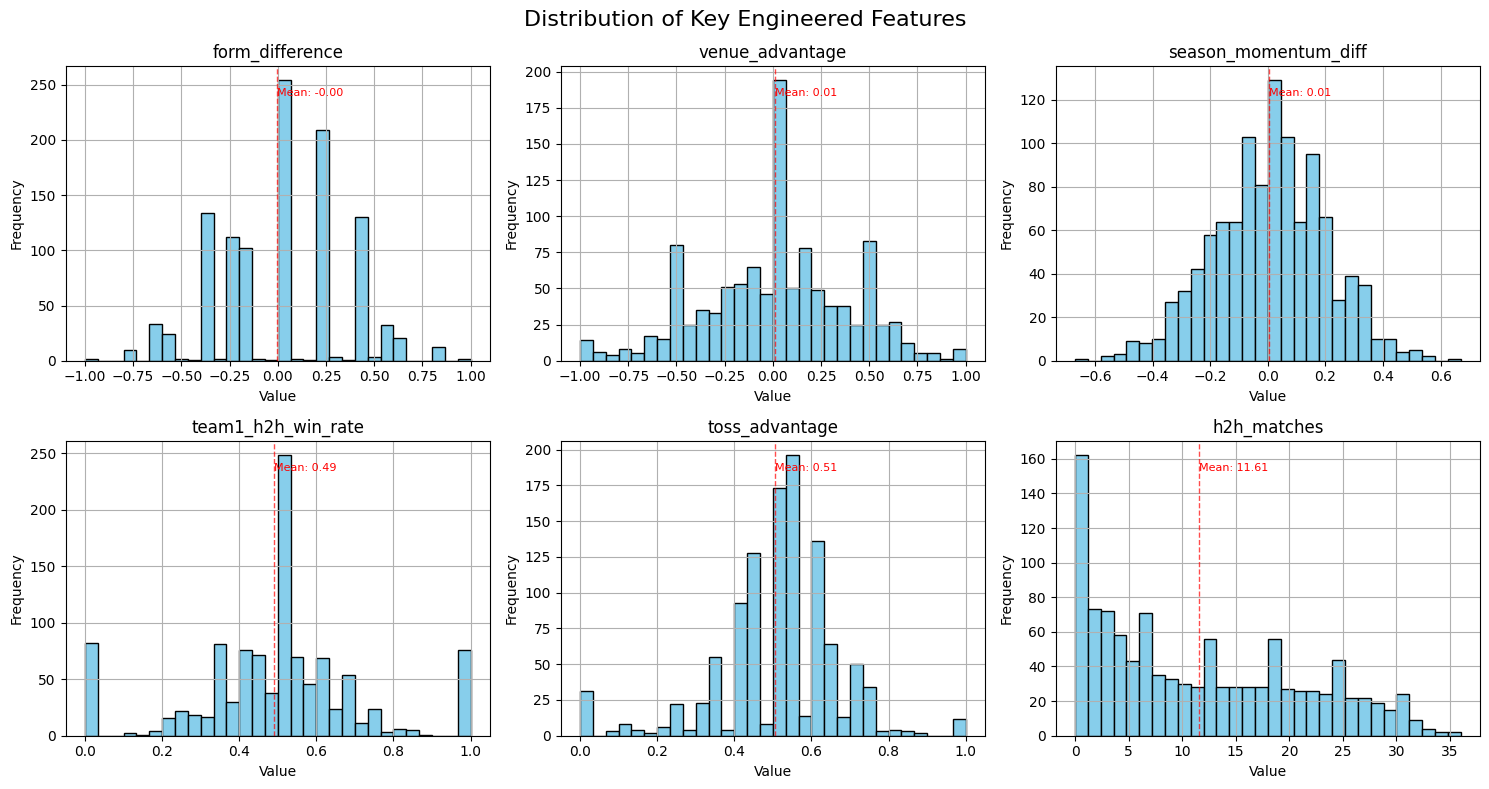


FEATURE ENGINEERING COMPLETE!

Final dataset shape: (1095, 50)
Total features created: 38

Files saved:
  - ../data/processed/match_features_engineered.csv
  - ../data/processed/player_batting_stats.csv
  - ../data/processed/player_bowling_stats.csv

Ready for model building!


In [54]:

print("\n" + "="*50)
print("FEATURE IMPORTANCE PREVIEW")
print("="*50)

# Create binary target variable (1 if team1 wins, 0 if team2 wins)
features_df['target'] = (features_df['winner'] == features_df['team1']).astype(int)

# Get only truly numerical features (exclude strings and categorical)
numerical_features = features_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove id, season (if numeric), and target from features
features_to_exclude = ['match_id', 'target', 'season']
numerical_features = [f for f in numerical_features if f not in features_to_exclude]

print(f"Found {len(numerical_features)} numerical features for correlation analysis")

# Quick correlation with target
if len(numerical_features) > 0:
    target_corr = features_df[numerical_features].corrwith(
        features_df['target']
    ).abs().sort_values(ascending=False)
    
    print("\nTop 10 features by correlation with winning:")
    print(target_corr.head(10))
else:
    print("Warning: No numerical features found for correlation analysis")

# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribution of Key Engineered Features', fontsize=16)

important_features = ['form_difference', 'venue_advantage', 'season_momentum_diff', 
                     'team1_h2h_win_rate', 'toss_advantage', 'h2h_matches']

# Filter to only features that actually exist and are numeric
important_features = [f for f in important_features if f in numerical_features]

for idx, feature in enumerate(important_features[:6]):  # Only plot up to 6 features
    ax = axes[idx // 3, idx % 3]
    features_df[feature].hist(bins=30, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Add mean line
    mean_val = features_df[feature].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', 
            rotation=0, color='red', fontsize=8)

# Hide any unused subplots
for idx in range(len(important_features), 6):
    axes[idx // 3, idx % 3].axis('off')

plt.tight_layout()
plt.savefig('../reports/figures/feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("FEATURE ENGINEERING COMPLETE!")
print("="*50)
print(f"\nFinal dataset shape: {features_df.shape}")
print(f"Total features created: {len(numerical_features)}")
print("\nFiles saved:")
print("  - ../data/processed/match_features_engineered.csv")
print("  - ../data/processed/player_batting_stats.csv") 
print("  - ../data/processed/player_bowling_stats.csv")
print("\nReady for model building!")